## Movie Recomendation System

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

#### Loading Data

In [2]:
#Ratings of users on the movies
ratings_data = pd.read_csv("data/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
ratings_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
#Demographics of users
users_data = pd.read_csv("data/u.user", sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])
users_data.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
movies_data = pd.read_csv("data/u.item", sep="|", encoding='latin-1', header=None,
                     names=[
                         "movie_id", "title", "release_date", "video_release_date", "IMDb_URL"
                     ] + [f"genre_{i}" for i in range(19)],
                     usecols=range(24))
movies_data.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,genre_0,genre_1,genre_2,genre_3,genre_4,...,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Build (Merge) The Datasets

In [5]:
data = ratings_data.merge(movies_data[['movie_id', 'title']], on='movie_id')
data = data.merge(users_data[['user_id', 'age', 'gender', 'occupation']], on='user_id')

# Drop timestamp if not used
data.drop('timestamp', axis=1, inplace=True)
data.head()

,user_id,movie_id,rating,title,age,gender,occupation
0,196,242,3,Kolya (1996),49,M,writer
1,186,302,3,L.A. Confidential (1997),39,F,executive
2,22,377,1,Heavyweights (1994),25,M,writer
3,244,51,2,Legends of the Fall (1994),28,M,technician
4,166,346,1,Jackie Brown (1997),47,M,educator


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     100000 non-null  int64 
 1   movie_id    100000 non-null  int64 
 2   rating      100000 non-null  int64 
 3   title       100000 non-null  object
 4   age         100000 non-null  int64 
 5   gender      100000 non-null  object
 6   occupation  100000 non-null  object
dtypes: int64(4), object(3)
memory usage: 5.3+ MB


#### Explatory Data Analysis

##### 1-Basic Data Information 

In [7]:
print("Data shape:", data.shape)
print("Unique users:", data['user_id'].nunique())
print("Unique movies:", data['movie_id'].nunique())
print("Unique ratings:", data['rating'].unique())
print("Users age range:", data['age'].min(), "-", data['age'].max())

data.head()

Data shape: (100000, 7)
Unique users: 943
Unique movies: 1682
Unique ratings: [3 1 2 4 5]
Users age range: 7 - 73


,user_id,movie_id,rating,title,age,gender,occupation
0,196,242,3,Kolya (1996),49,M,writer
1,186,302,3,L.A. Confidential (1997),39,F,executive
2,22,377,1,Heavyweights (1994),25,M,writer
3,244,51,2,Legends of the Fall (1994),28,M,technician
4,166,346,1,Jackie Brown (1997),47,M,educator


##### 2-Distribution of Ratings

C:\Users\Beast\AppData\Local\Temp\ipykernel_34592\1397164455.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='rating', palette='viridis')


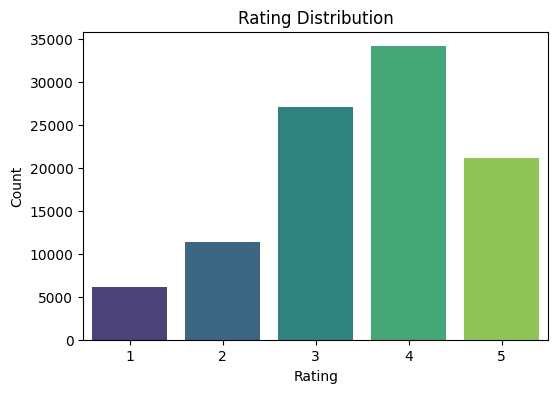

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='rating', palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Most ratings are 4 or 5, showing that users tend to give favorable feedback.

In [9]:
#Average Rating Score:
average_rating = data['rating'].mean()
print("Average Rating Score:", average_rating)

Average Rating Score: 3.52986


The average rating score is 3.5

##### 3-Ratings Per User

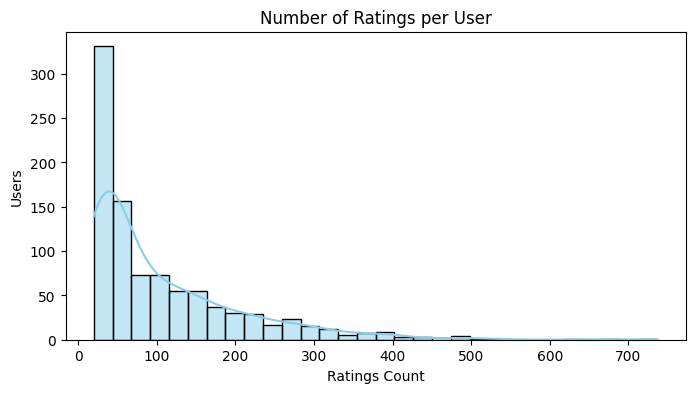

In [10]:
ratings_per_user = data.groupby('user_id').size()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_user, bins=30, kde=True, color='skyblue')
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.show()


We can see that each user has rated at least 20~30 movies.

##### 4-Ratings Per Movie

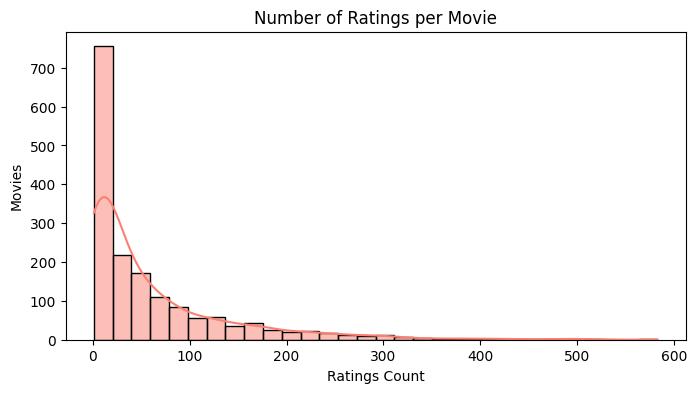

In [11]:
ratings_per_movie = data.groupby('movie_id').size()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_movie, bins=30, kde=True, color='salmon')
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Movies")
plt.show()


Most movies have few ratings; only a small number are frequently rated, showing a strong popularity bias in the dataset.

##### 5-Heatmap of User-Movie Ratings (Sample)

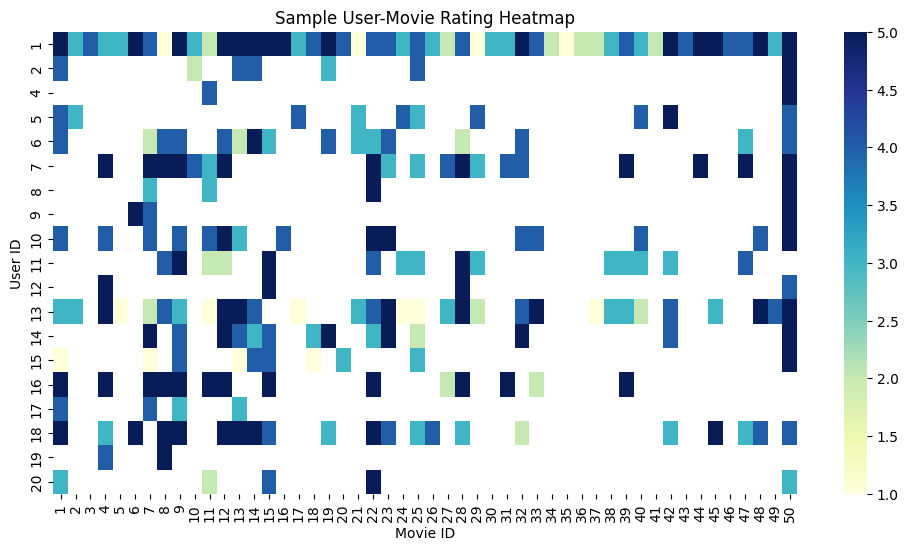

In [12]:
sample = data[(data['user_id'] <= 20) & (data['movie_id'] <= 50)]
pivot = sample.pivot_table(index='user_id', columns='movie_id', values='rating')

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlGnBu', cbar=True)
plt.title("Sample User-Movie Rating Heatmap")
plt.xlabel("Movie ID")
plt.ylabel("User ID")
plt.show()


##### 6-Demographics of Users

###### 6.1-Gender Distribution

C:\Users\Beast\AppData\Local\Temp\ipykernel_34592\3328832882.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users_data, x='gender', palette='pastel')


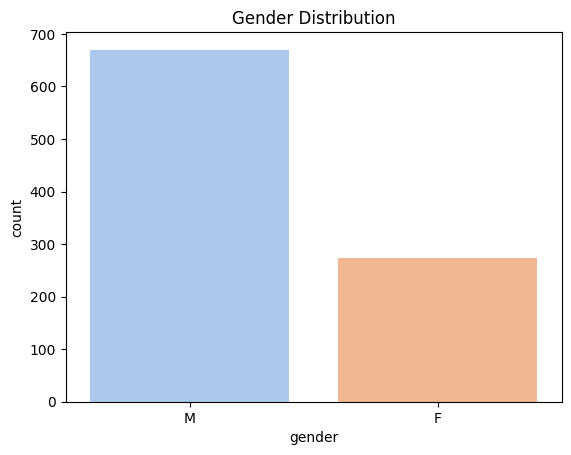

In [13]:
sns.countplot(data=users_data, x='gender', palette='pastel')
plt.title("Gender Distribution")
plt.show()

Most users in the dataset are males

###### 6.2-Age Distribution

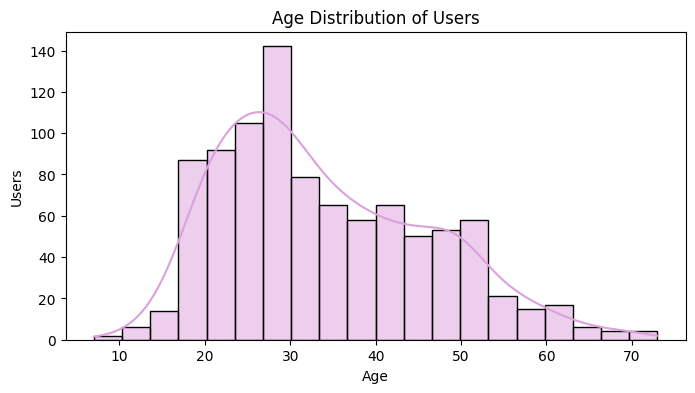

In [14]:
plt.figure(figsize=(8,4))
sns.histplot(users_data['age'], bins=20, kde=True, color='plum')
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Users")
plt.show()


The age is ranging from 7 to 79 years with an average of 27 years.

###### 6.3-Occupation Breakdown

C:\Users\Beast\AppData\Local\Temp\ipykernel_34592\1447256676.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users_data, y='occupation', order=users_data['occupation'].value_counts().index, palette='coolwarm')


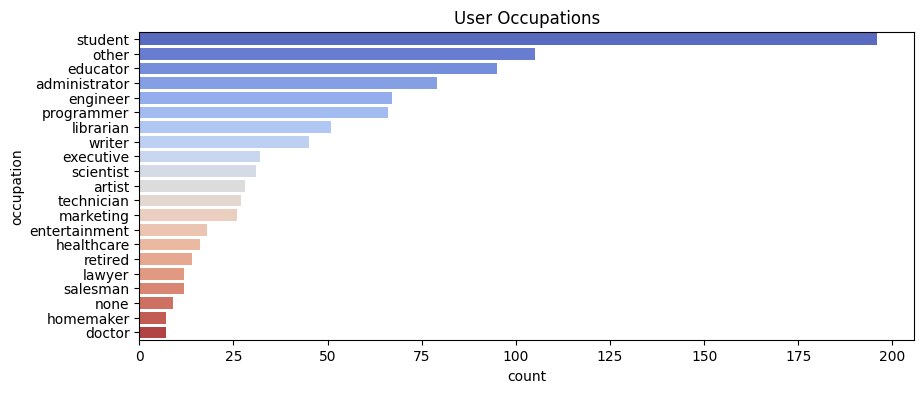

In [15]:
plt.figure(figsize=(10,4))
sns.countplot(data=users_data, y='occupation', order=users_data['occupation'].value_counts().index, palette='coolwarm')
plt.title("User Occupations")
plt.show()

Most of the users are students

#### Loading the Train and Test data (already splitted and available with the data folder)

In [16]:
#Load pre-defined split
train_data = pd.read_csv("data/u1.base", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
test_data = pd.read_csv("data/u1.test", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

#Drop timestamps
train_data.drop('timestamp', axis=1, inplace=True)
test_data.drop('timestamp', axis=1, inplace=True)

In [17]:
train_data.head()

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [18]:
test_data.head()

,user_id,movie_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


#### User-Item Matrix
Lets make a pivot table in order to make rows are users and columns are movies. And values are rating

In [19]:
user_item_matrix = train_data.pivot_table(index='user_id', columns='movie_id', values='rating')
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* As it can be seen from table above, rows are users, columns are movies and values are ratings.
* For example user 1 gives 3.0 rating to movie_id "2" and gives 4.0 rating to movie_id "3".

#### Calculate User Similarity
We will use cosine similarity

Cosine similarity measures the angle between two vectors:

It compares how similar the rating patterns of two users are.

It ignores magnitude (i.e., it doesn’t care if User A always rates 1 star higher than User B).
Range:

+1 = identical preferences

0 = no correlation

–1 = opposite preferences

* You can find the most similar users to a given user.
* Recommend movies that similar users liked — even if the target user hasn’t rated them.

In [20]:
#Fill NaN with 0 for similarity calc
user_item_matrix = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_item_matrix.index, 
                                  columns=user_item_matrix.index)

In [21]:
user_similarity_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.097021,0.052469,0.021162,0.193545,0.290114,0.200438,0.097786,0.060791,0.200926,...,0.252187,0.090728,0.216186,0.139478,0.156937,0.095265,0.222958,0.158151,0.133090,0.252778
2,0.097021,1.000000,0.051348,0.084426,0.015516,0.187717,0.074479,0.023262,0.108167,0.078176,...,0.083045,0.298811,0.308608,0.403810,0.282896,0.213233,0.189257,0.132806,0.126597,0.101784
3,0.052469,0.051348,1.000000,0.145660,0.037180,0.084526,0.015718,0.086400,0.000000,0.030909,...,0.041330,0.036956,0.135750,0.063940,0.102082,0.034064,0.133720,0.083537,0.081230,0.019676
4,0.021162,0.084426,0.145660,1.000000,0.017291,0.000000,0.037566,0.046087,0.000000,0.023232,...,0.014238,0.047742,0.127305,0.118947,0.089016,0.039116,0.120521,0.135669,0.125925,0.035586
5,0.193545,0.015516,0.037180,0.017291,1.000000,0.158552,0.170890,0.157488,0.053846,0.089508,...,0.284295,0.074215,0.086345,0.063759,0.126358,0.068145,0.198118,0.142141,0.150000,0.239803


#### Recommend Movies Based on Similar Users

In [22]:
def recommend_movies(user_id, user_matrix, similarity_df, top_n=5):
    #1. Find similar users (excluding the target user)
    similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False)
    
    #2. Get ratings from these similar users
    similar_users_ratings = user_matrix.loc[similar_users.index]
    
    #3. Compute weighted ratings for each movie
    weighted_ratings = similar_users_ratings.T.dot(similar_users)
    weighted_ratings /= similar_users.sum()
    
    #4. Exclude movies the target user has already rated
    seen_movies = user_matrix.loc[user_id]
    unseen = seen_movies[seen_movies == 0].index
    
    #5. Recommend top N movies the user hasn't seen, sorted by predicted score
    recommendations = weighted_ratings[unseen].sort_values(ascending=False).head(top_n)
    return recommendations

#### Evaluate Using Precision@K
Precision@K (Precision at Top-K) measures the accuracy of the top K recommendations made by the system.

In [23]:
def precision_at_k(user_id, k=5):
    if user_id not in test_data['user_id'].values:
        print(f"User ID {user_id} not found in test data.")
        return None

    #Get top-k recommended movies
    recs = recommend_movies(user_id, user_item_matrix, user_similarity_df, top_n=k)

    #Map movie IDs to titles (assumes you have a movie_id -> title mapping)
    movie_id_to_title = dict(zip(movies_data['movie_id'], movies_data['title']))
    rec_titles = [movie_id_to_title.get(mid, f"Movie {mid}") for mid in recs.index]

    #Movies the user rated 4 or 5 in the test set (considered relevant)
    user_test_data = test_data[test_data['user_id'] == user_id]
    relevant = set(user_test_data[user_test_data['rating'] >= 4]['movie_id'])
    relevant_titles = [movie_id_to_title.get(mid, f"Movie {mid}") for mid in relevant]

    #Count hits
    hits = [1 for movie_id in recs.index if movie_id in relevant]
    num_hits = sum(hits)
    precision = num_hits / k

    print(f"\n🎯 Precision@{k} for User ID {user_id}:")
    print(f"- 🧠 Top {k} Recommended Movies: {rec_titles}")
    print(f"- ✅ Relevant Movies (rated ≥ 4): {relevant_titles}")
    print(f"- ✔️ Hits (Correct Recommendations): {num_hits}")
    print(f"- 📊 Precision@{k} = {num_hits} / {k} = {precision:.3f}")

    return precision


#### Main Application

In [24]:
import random

#Get all unique user IDs in the test set
test_users = test_data['user_id'].unique()

#Randomly select up to 100 users
num_users = min(5, len(test_users))
random_users = random.sample(list(test_users), num_users)

#Compute precision@5 for each randomly selected user — only call the function once per user
precisions = []
for uid in random_users:
    score = precision_at_k(uid, k=5)
    if score is not None:
        precisions.append(score)

#Calculate and print the average
if precisions:
    print("Average Precision@5:", sum(precisions) / len(precisions))
else:
    print("No valid users found for evaluation.")


🎯 Precision@5 for User ID 446:
- 🧠 Top 5 Recommended Movies: ['Contact (1997)', 'Titanic (1997)', 'Star Wars (1977)', 'Fargo (1996)', 'Game, The (1997)']
- ✅ Relevant Movies (rated ≥ 4): []
- ✔️ Hits (Correct Recommendations): 0
- 📊 Precision@5 = 0 / 5 = 0.000

🎯 Precision@5 for User ID 284:
- 🧠 Top 5 Recommended Movies: ['English Patient, The (1996)', 'Contact (1997)', 'Titanic (1997)', 'Air Force One (1997)', 'Scream (1996)']
- ✅ Relevant Movies (rated ≥ 4): ['Contact (1997)', 'Conspiracy Theory (1997)', 'Full Monty, The (1997)', 'Fly Away Home (1996)', 'Ice Storm, The (1997)', 'Boogie Nights (1997)', "Eve's Bayou (1997)", 'Apostle, The (1997)', 'Jackie Brown (1997)', 'English Patient, The (1996)']
- ✔️ Hits (Correct Recommendations): 2
- 📊 Precision@5 = 2 / 5 = 0.400

🎯 Precision@5 for User ID 199:
- 🧠 Top 5 Recommended Movies: ['Star Wars (1977)', 'Contact (1997)', 'English Patient, The (1996)', 'Return of the Jedi (1983)', 'Godfather, The (1972)']
- ✅ Relevant Movies (rated ≥ 4):

#### Item-Based Collaborative Filtering

In [25]:
item_user_matrix = train_data.pivot_table(index='movie_id', columns='user_id', values='rating').fillna(0)
item_user_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Compute cosine similarity between items
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)
item_similarity_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.357646,0.309390,0.373556,0.233597,0.088069,0.542065,0.410063,0.421738,0.235267,...,0.038276,0.0,0.000000,0.000000,0.038276,0.0,0.0,0.0,0.051035,0.051035
2,0.357646,1.000000,0.221600,0.419180,0.282711,0.084006,0.334544,0.285908,0.192594,0.119709,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.087781,0.087781
3,0.309390,0.221600,1.000000,0.262853,0.144386,0.078189,0.307612,0.186519,0.288698,0.147544,...,0.000000,0.0,0.000000,0.000000,0.035556,0.0,0.0,0.0,0.000000,0.106668
4,0.373556,0.419180,0.262853,1.000000,0.273416,0.099500,0.402405,0.399622,0.339125,0.184911,...,0.000000,0.0,0.104416,0.104416,0.041766,0.0,0.0,0.0,0.062650,0.083533
5,0.233597,0.282711,0.144386,0.273416,1.000000,0.017107,0.275840,0.184932,0.206313,0.039897,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.105021


In [27]:
def recommend_movies_item_based(user_id, item_user_matrix, item_similarity_df, top_n=5):
    user_ratings = item_user_matrix.loc[:, user_id]
    
    # Only consider items the user rated > 0
    rated_items = user_ratings[user_ratings > 0].index
    
    # Compute weighted score for each movie
    scores = pd.Series(dtype='float64')
    for item in rated_items:
        similarity_scores = item_similarity_df[item]
        scores = scores.add(similarity_scores * user_ratings[item], fill_value=0)
    
    # Remove already rated movies
    scores = scores.drop(index=rated_items, errors='ignore')
    
    # Sort and recommend top N
    top_recommendations = scores.sort_values(ascending=False).head(top_n)
    return top_recommendations

In [28]:
movies_data.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,genre_0,genre_1,genre_2,genre_3,genre_4,...,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
test_data.head()

,user_id,movie_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


#### Results of Item-Based Filtering

In [39]:
def get_movie_titles(movie_ids):
    return movies_data.set_index('movie_id').loc[movie_ids]['title'].values

user_id = 117
recommendations = recommend_movies_item_based(user_id, item_user_matrix, item_similarity_df, top_n=5)

print(f"🎬 Top Recommendations for User {user_id}:")
for movie_id in recommendations.index:
    try:
        title = movies_data[movies_data['movie_id'] == movie_id]['title'].iloc[0]
        print(f"- {title}")
    except IndexError:
        print(f"- Title not found for movie_id {movie_id}")


🎬 Top Recommendations for User 117:
- Star Wars (1977)
- Return of the Jedi (1983)
- Raiders of the Lost Ark (1981)
- Terminator, The (1984)
- Fugitive, The (1993)


#### Trying Matrix Factorization (SVD)

In [31]:
train_data.head()

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [33]:
from surprise import Dataset, Reader, SVD, accuracy

#Combine all data and load into Surprise
reader = Reader(rating_scale=(0.5, 5.0))
full_data = pd.concat([train_data, test_data])
surprise_data = Dataset.load_from_df(full_data[['user_id', 'movie_id', 'rating']], reader)

#Build the full trainset (Surprise requires internal mapping)
trainset = surprise_data.build_full_trainset()

#Create testset from test_data using internal IDs
testset = [
    (row['user_id'], row['movie_id'], row['rating'])
    for _, row in test_data.iterrows()
]

In [34]:
# Step 4: Train the model
model = SVD()
model.fit(trainset)

# Step 5: Predict and evaluate
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6768


0.6768123034004371

#### Make Recommendations for a User

In [35]:
def get_top_n_recommendations(model, trainset, user_id, movies_data, n=5):
    # Get the inner user ID from raw user ID
    try:
        inner_id = trainset.to_inner_uid(user_id)
    except ValueError:
        print(f"User {user_id} not in training set.")
        return []

    # Get all movie IDs in the dataset
    all_movie_ids = trainset._raw2inner_id_items.keys()

    # Get the movies this user has already rated
    rated_items = set(j for (j, _) in trainset.ur[inner_id])

    # Predict ratings for unseen items
    unseen = [movie_id for movie_id in all_movie_ids if trainset.to_inner_iid(movie_id) not in rated_items]
    
    predictions = [model.predict(user_id, movie_id) for movie_id in unseen]

    # Sort predictions by estimated rating
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Get movie titles
    recommended_movies = []
    for pred in top_n:
        title = movies_data[movies_data['movie_id'] == int(pred.iid)]['title'].values[0]
        recommended_movies.append((title, round(pred.est, 2)))

    return recommended_movies


In [40]:
user_id = 211  # Any user from your test or train set
top_recs = get_top_n_recommendations(model, trainset, user_id, movies_data, n=5)

print(f"\n🎬 Top 5 Recommendations for User {user_id}:")
for title, score in top_recs:
    print(f"- {title} (Predicted rating: {score})")



🎬 Top 5 Recommendations for User 211:
- Monty Python and the Holy Grail (1974) (Predicted rating: 4.33)
- Boot, Das (1981) (Predicted rating: 4.3)
- Casablanca (1942) (Predicted rating: 4.2)
- Wrong Trousers, The (1993) (Predicted rating: 4.19)
- Grand Day Out, A (1992) (Predicted rating: 4.18)
